## Examples of N-dimensional interpolation
 
* could be used for example to read and interpolate an lookup table or IRF.
* In this example, we load a sample energy reconstruction lookup-table from a FITS file
* In this case it is only in 2D cube (to keep the file size small): `SIZE` vs `IMPACT-DISTANCE`, however the same method will work for any dimensionality

In [1]:
import matplotlib.pylab as plt
import numpy as np
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

from ctapipe.utils.datasets import get_path
from ctapipe.utils import Histogram
%matplotlib notebook

###Load an example datacube 
(an energy table generated for a
small subset of HESS simulations) to use as a lookup table. Here
we will use the `Histogram` class, which automatically loads both
the data cube and creates arrays for the coordinates of each
axis.

In [2]:
testfile = get_path("hess_ct001_energylut.fits.gz")
energy_hdu = fits.open(testfile)['MEAN']
energy_table = Histogram(initFromFITS=energy_hdu)
print(energy_table)

Histogram(name='Histogram', axes=['LSIZ' 'DIST'], nbins=(100, 100), ranges=[[  5.00000000e-01   6.00000000e+00]
 [  0.00000000e+00   2.00000000e+03]])


### construct an interpolator that we can use to get values at any point:

Here we will use a `RegularGridInterpolator`, since it is the most appropriate for this type of data, but others are available (see the SciPy documentation)

In [4]:
centers = [energy_table.bin_centers(ii) for ii in range(energy_table.ndims)]
energy_lookup = RegularGridInterpolator(centers, energy_table.hist,
                                        bounds_error=False,fill_value=-100)

`energy_lookup` is now just a continuous function of `log(SIZE)`,
`DISTANCE` in m. 

### Now plot some curves from the interpolator.  

Note that the LUT we used is does not have very high statistics,
so the interpolation starts to be affected by noise at the high
end. In a real case, we would want to use a table that has been
sanitized (smoothed and extrapolated)

<IPython.core.display.Javascript object>


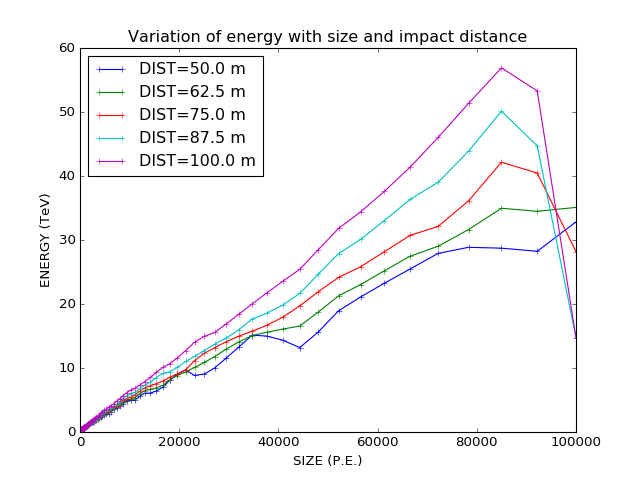

In [5]:
lsize = np.linspace(1.5, 5.0, 100)
dists = np.linspace(50, 100, 5)

plt.figure()
plt.title("Variation of energy with size and impact distance")
plt.xlabel("SIZE (P.E.)")
plt.ylabel("ENERGY (TeV)")

for dist in dists:
    plt.plot(10**lsize, 10**energy_lookup((lsize, dist)), '+-',
             label="DIST={:.1f} m".format(dist))

plt.legend(loc="best")

Using the interpolator, reinterpolate the lookup table onto an $N \times N$
grid (regardless of its original dimensions):

In [7]:
N = 300
xmin, xmax = energy_table.bin_centers(0)[0], energy_table.bin_centers(0)[-1]
ymin, ymax = energy_table.bin_centers(1)[0], energy_table.bin_centers(1)[-1]
xx,yy = np.linspace(xmin,xmax,N), np.linspace(ymin, ymax, N)
X, Y = np.meshgrid( xx,yy )
points = list(zip(X.ravel(),Y.ravel()))
E = energy_lookup(points).reshape((N, N))

Now, let's plot the original table and the new one (E).  The color bar shows $\log_{10}(E)$ in TeV

In [8]:
plt.figure(figsize=(12,5))
plt.spectral()

# the uninterpolated table
plt.subplot(1,2,1)
plt.xlim(1.5,5)
plt.ylim(0,500)
plt.xlabel("log10(SIZE)")
plt.ylabel("Impact Dist (m)")
plt.pcolormesh(energy_table.binCenters(0), energy_table.binCenters(1), energy_table.hist.T)
plt.title("Raw table, uninterpolated {0}".format(energy_table.hist.T.shape))
cb = plt.colorbar()
cb.set_label("$\log_{10}(E/\mathrm{TeV})$")

# the interpolated table
plt.subplot(1,2,2)
plt.pcolormesh(np.linspace(xmin,xmax,N), np.linspace(ymin, ymax, N),E)
plt.xlim(1.5,5)
plt.ylim(0,500)
plt.xlabel("log10(SIZE)")
plt.ylabel("Impact Dist(m)")
plt.title("Interpolated to a ({0}, {0}) grid".format(N))
cb = plt.colorbar()
cb.set_label("$\log_{10}(E/\mathrm{TeV})$")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

AttributeError: 'Histogram' object has no attribute 'binCenters'

In the high-stats central region, we get a nice smooth interpolation function. Of course we can see that there are a few more steps to take before using this table:
* need to deal with cases where the table had low stats near the edges (smooth or extrapolate, or set bounds)
* may need to smooth the table even where there are sufficient stats, to avoid wiggles